### Шаг 1: Импорт необходимых библиотек

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
!pip install -U feature-engine
from feature_engine.creation import MathFeatures  # Импорт MathFeatures из feature_engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.1/364.1 kB 11.3 MB/s eta 0:00:00


### Шаг 2: Загрузка данных

In [3]:
# Используем датасет для классификации сердечных заболеваний из Kaggle
!kaggle datasets download -d fedesoriano/heart-failure-prediction

Dataset URL: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction
License(s): ODbL-1.0
  0% 0.00/8.56k [00:00<?, ?B/s]
100% 8.56k/8.56k [00:00<00:00, 12.0MB/s]


In [4]:
# Распаковка загруженного датасета (это zip-файл)
import zipfile
import os

with zipfile.ZipFile('/content/heart-failure-prediction.zip', 'r') as zip_ref:
    zip_ref.extractall('heart_failure_data')

In [5]:
data = pd.read_csv('/content/heart_failure_data/heart.csv')
X = data.drop('HeartDisease', axis=1)  # Все колонки, кроме целевой
y = data['HeartDisease']  # Целевая переменная

In [6]:
# Выведем датасет, посмотрим его размер и информацию о нём
print(X.head())
print('--------------------------------')
print(X.shape)
print('--------------------------------')
print(X.info())
print('--------------------------------')
print(X.isna().sum())

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  
0              N      0.0       Up  
1              N      1.0     Flat  
2              N      0.0       Up  
3              Y      1.5     Flat  
4              N      0.0       Up  
--------------------------------
(918, 11)
--------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age            

**Выводы:**
- Признаки включают как числовые (например, Age, RestingBP, Cholesterol, MaxHR, Oldpeak), так и категориальные (например, Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope).
- В датасете отсутствуют пропуски. Это говорит, что нам не нужно обрабатывать пропуски.
- 5 признаков типа int64, 1 признак типа float64, 5 признаков типа object (категориальные данные).

### Шаг 3: Обработка данных и первоначальное обучение модели

In [7]:
# Кодирование категориальных признаков
X_encoded = pd.get_dummies(X, drop_first=True)
X_encoded_df = pd.DataFrame(X_encoded, columns=X_encoded.columns)

# Нормализация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded_df)

In [8]:
# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=66)

# Обучение первоначальной модели
model = RandomForestClassifier(random_state=66)
model.fit(X_train, y_train)

# Оценка качества первоначальной модели
y_pred = model.predict(X_test)
initial_accuracy = accuracy_score(y_test, y_pred)
print(f"Точность первоначальной модели Random Forest: {initial_accuracy:.4f}")


Точность первоначальной модели Random Forest: 0.8533


### Шаг 4: Генерация новых полиномиальных признаков используя MathFeatures из feature-engine

In [9]:
# Определим пары признаков для взаимодействия
# pairs = [('Age', 'RestingBP'), ('Cholesterol', 'MaxHR'), ('Oldpeak', 'RestingBP')]
pairs = [
    ('Age', 'RestingBP'),
    ('Cholesterol', 'MaxHR'),
    ('Oldpeak', 'RestingBP'),
    ('Age', 'Cholesterol'),
    ('MaxHR', 'Oldpeak'),
    ('RestingBP', 'Cholesterol'),
    ('Age', 'MaxHR'),
    ('Oldpeak', 'Cholesterol'),
    ('Age', 'Oldpeak')
]

# Создадим список новых имен признаков
new_feature_names = [f"{x}_mul_{y_temp}" for x, y_temp in pairs]

# Инициализируем список трансформеров
math_transformers = []
for (x, y_temp), name in zip(pairs, new_feature_names):
    math_feat = MathFeatures(
        variables=[x, y_temp],
        func="prod",  # Используем строку "prod" вместо np.prod
        new_variables_names=[name],
        drop_original=False  # Сохраним исходные признаки
    )
    math_transformers.append(math_feat)

# Применяем трансформеры последовательно
X_math = X_encoded_df.copy()
for transformer in math_transformers:
    transformer.fit(X_math)
    X_math = transformer.transform(X_math)

print("Новые признаки после применения MathFeatures:")
print(X_math[new_feature_names].head())

# Проверка размерности X_math и y
print(f"Размер X_math: {X_math.shape}")
print(f"Размер y: {y.shape}")
print(f"Тип y: {type(y)}")

# Масштабирование данных с новыми признаками
scaler_math = StandardScaler()
X_math_scaled = scaler_math.fit_transform(X_math)

# Проверка размерности X_math_scaled и y перед разделением
print(f"Размер X_math_scaled: {X_math_scaled.shape}")
print(f"Размер y: {y.shape}")

# Разделение данных
X_train_math, X_test_math, y_train_math, y_test_math = train_test_split(X_math_scaled, y, test_size=0.2, random_state=66)

# Обучение модели на данных с новыми признаками
model_math = RandomForestClassifier(random_state=66)
model_math.fit(X_train_math, y_train_math)

# Оценка модели с новыми признаками
y_pred_math = model_math.predict(X_test_math)
math_accuracy = accuracy_score(y_test_math, y_pred_math)
print(f"Точность модели с новыми признаками MathFeatures: {math_accuracy:.4f}")


Новые признаки после применения MathFeatures:
   Age_mul_RestingBP  Cholesterol_mul_MaxHR  Oldpeak_mul_RestingBP  \
0               5600                  49708                    0.0   
1               7840                  28080                  160.0   
2               4810                  27734                    0.0   
3               6624                  23112                  207.0   
4               8100                  23790                    0.0   

   Age_mul_Cholesterol  MaxHR_mul_Oldpeak  RestingBP_mul_Cholesterol  \
0                11560                0.0                      40460   
1                 8820              156.0                      28800   
2                10471                0.0                      36790   
3                10272              162.0                      29532   
4                10530                0.0                      29250   

   Age_mul_MaxHR  Oldpeak_mul_Cholesterol  Age_mul_Oldpeak  
0           6880                      0

### Шаг 5: Оценка важности новых признаков

In [17]:
importances = model_math.feature_importances_
feature_importances = pd.Series(importances, index=X_math.columns).sort_values(ascending=False)

# Отбор новых признаков (исключая исходные)
new_feature_importances = feature_importances[new_feature_names]

# Выбор топ-N новых признаков
N = 2  # Количество новых признаков равно 2, можно любое
top_new_features = new_feature_importances.head(N).index.tolist()
print(f"Топ-{N} новых признаков по важности:")
for feat in top_new_features:
    print(feat)


Топ-2 новых признаков по важности:
Age_mul_RestingBP
Cholesterol_mul_MaxHR


### Шаг 6: Дополнение исходных данных наиболее важными признаками

In [18]:
# Создание финального набора данных с выбранными признаками
X_final_df = pd.concat([X_encoded_df.reset_index(drop=True), X_math[top_new_features].reset_index(drop=True)], axis=1)

# Масштабирование данных
scaler_final = StandardScaler()
X_final_scaled = scaler_final.fit_transform(X_final_df)

# Разделение данных
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final_scaled, y, test_size=0.2, random_state=66)

### Шаг 7: Повторное обучение модели

In [19]:
model_final = RandomForestClassifier(random_state=66)
model_final.fit(X_train_final, y_train_final)

# Оценка финальной модели
y_pred_final = model_final.predict(X_test_final)
final_accuracy = accuracy_score(y_test_final, y_pred_final)
print(f"Точность финальной модели с топ-{N} новыми признаками: {final_accuracy:.4f}")


Точность финальной модели с топ-2 новыми признаками: 0.8641


### Шаг 8: Построение кривой обучения

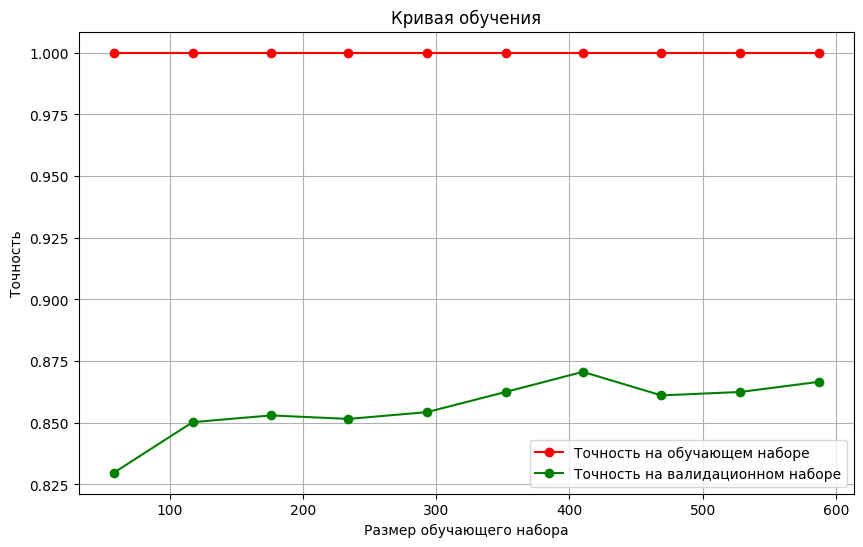

In [20]:
train_sizes, train_scores, test_scores = learning_curve(
    model_final, X_train_final, y_train_final, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Точность на обучающем наборе")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Точность на валидационном наборе")
plt.title("Кривая обучения")
plt.xlabel("Размер обучающего набора")
plt.ylabel("Точность")
plt.legend(loc="best")
plt.grid()
plt.show()

In [21]:
# Сравнение результатов
print(f"Точность первоначальной модели: {initial_accuracy:.4f}")
print(f"Точность модели с новыми признаками MathFeatures: {math_accuracy:.4f}")
print(f"Точность финальной модели с топ-{N} новыми признаками: {final_accuracy:.4f}")

Точность первоначальной модели: 0.8533
Точность модели с новыми признаками MathFeatures: 0.8424
Точность финальной модели с топ-2 новыми признаками: 0.8641


**Вывод:**
- Есть прибавление в качестве после добавление признаков MathFeatures, модель повысила точность с 0,8533 до 0,8641.

### Шаг 9: Эксперимент с разным количеством новых признаков

In [15]:
accuracies = []
num_features_list = [1, 2, 3, 4, 5, 10]

for num_features in num_features_list:
    selected_features = new_feature_importances.head(num_features).index.tolist()
    selected_new_features = X_math[selected_features]

    X_temp = pd.concat([X_encoded_df.reset_index(drop=True), selected_new_features.reset_index(drop=True)], axis=1)
    X_temp_scaled = scaler.fit_transform(X_temp)

    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
        X_temp_scaled, y, test_size=0.2, random_state=66)

    model_temp = RandomForestClassifier(random_state=66)
    model_temp.fit(X_train_temp, y_train_temp)

    y_pred_temp = model_temp.predict(X_test_temp)
    acc = accuracy_score(y_test_temp, y_pred_temp)
    accuracies.append(acc)
    print(f"Точность с {num_features} новыми признаками: {acc:.4f}")


Точность с 1 новыми признаками: 0.8533
Точность с 2 новыми признаками: 0.8641
Точность с 3 новыми признаками: 0.8587
Точность с 4 новыми признаками: 0.8424
Точность с 5 новыми признаками: 0.8478
Точность с 10 новыми признаками: 0.8424


### Шаг 10: Построение графика зависимости точности от количества новых признаков

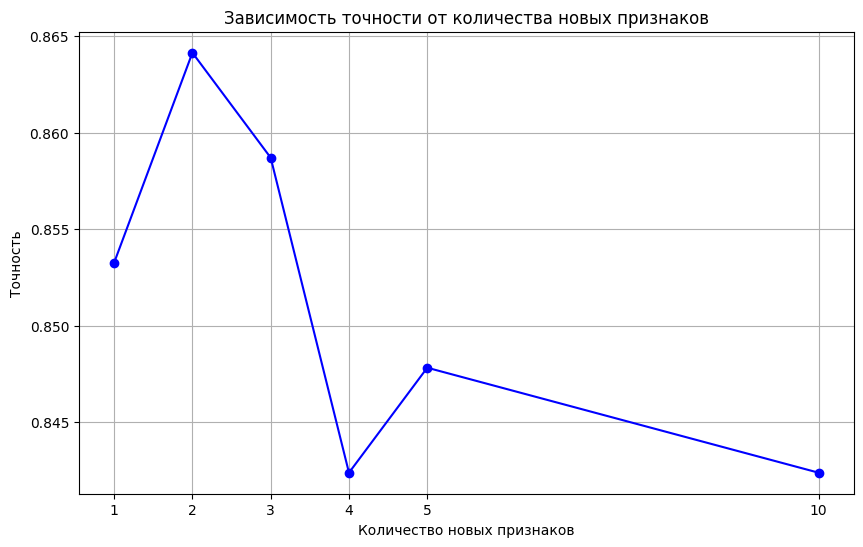

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(num_features_list, accuracies, marker='o', linestyle='-', color='b')
plt.title("Зависимость точности от количества новых признаков")
plt.xlabel("Количество новых признаков")
plt.ylabel("Точность")
plt.xticks(num_features_list)
plt.grid()
plt.show()

**Выводы:**
- Рекомендуется использовать от 1 до 3 новых признаков для оптимизации производительности модели на данном датасете. Далее идёт резкое продолжающееся ухудшение.
- Максимальный результат по метрикам качества был достигнут при добавлении 2 новых признаков, когда точность составила примерно 0.865. Это свидетельствует о том, что небольшое количество новых полиномиальных признаков может существенно улучшить предсказательную способность модели.